# Data preparation

In [1]:
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(dplyr)
library(tidyverse)
library(reshape2)
library(ggrepel)
library(data.table)
library(biomaRt)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following object is masked from 'package:utils':

    findMatches


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [133]:
# Input read_count file
df <- read.delim("data/gene_counts_raw.csv", row.names = 1, sep = ",")
dim(df)
head(df)

[1] 57820     7

,Geneid,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
0,ENSG00000223972,0,4,1,0,5,0
1,ENSG00000227232,34,531,758,632,558,496
2,ENSG00000243485,0,1,2,0,0,1
3,ENSG00000237613,0,0,0,0,0,0
4,ENSG00000268020,0,0,0,0,0,0
5,ENSG00000240361,0,0,0,0,0,0


In [23]:
# Get list of column names
col_names <- colnames(df)
col_names

[1] "Geneid"                      "X_filesTien_Cont1_S25sorted"
[3] "X_filesTien_Cont2_S26sorted" "X_filesTien_Cont3_S27sorted"
[5] "X_filesTien_Zn1_S28sorted"   "X_filesTien_Zn2_S29sorted"  
[7] "X_filesTien_Zn3_S30sorted"

In [24]:
# Connect to hg19/GRCh37 Ensembl archive
# Note: Using archive since hg19/GRCh37 is an older assembly
mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL",
                dataset = "hsapiens_gene_ensembl",
                host = "grch37.ensembl.org")
mart

Warning message:
"Ensembl will soon enforce the use of https.
Ensure the 'host' argument includes "https://""


Object of class 'Mart':
  Using the ENSEMBL_MART_ENSEMBL BioMart database
  Using the hsapiens_gene_ensembl dataset

In [25]:
# Get mapping
gene_info <- getBM(attributes = c("ensembl_gene_id", 
                                "external_gene_name",
                                "description",
                                "chromosome_name",
                                "start_position",
                                "end_position"),
                  filters = "ensembl_gene_id",
                  values = df$Geneid,
                  mart = mart)
head(gene_info)

,ensembl_gene_id,external_gene_name,description,chromosome_name,start_position,end_position
,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,ENSG00000000457,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbol;Acc:19285],1,169818772,169863408
2,ENSG00000000938,FGR,feline Gardner-Rasheed sarcoma viral oncogene homolog [Source:HGNC Symbol;Acc:3697],1,27938575,27961788
3,ENSG00000006555,TTC22,tetratricopeptide repeat domain 22 [Source:HGNC Symbol;Acc:26067],1,55245385,55266940
4,ENSG00000007933,FMO3,flavin containing monooxygenase 3 [Source:HGNC Symbol;Acc:3771],1,171060018,171086959
5,ENSG00000007968,E2F2,E2F transcription factor 2 [Source:HGNC Symbol;Acc:3114],1,23832922,23857712
6,ENSG00000008118,CAMK1G,calcium/calmodulin-dependent protein kinase IG [Source:HGNC Symbol;Acc:14585],1,209757062,209787283


In [33]:
# Merge with your original dataframe
df_with_names <- merge(df, gene_info, 
                      by.x = "Geneid", 
                      by.y = "ensembl_gene_id", 
                      all.x = TRUE)

# Check the first few rows
head(df_with_names)

# print dimension
dim(df_with_names)

,Geneid,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted,external_gene_name,description,chromosome_name,start_position,end_position
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,ENSG000000000031,497,6704,9591,5829,5506,3799,NA,NA,NA,NA,NA
2,ENSG00000000005,71,945,1295,815,729,496,TNMD,tenomodulin [Source:HGNC Symbol;Acc:17757],X,99839799,99854882
3,ENSG00000000419,185,2383,3464,3081,2884,2011,DPM1,"dolichyl-phosphate mannosyltransferase polypeptide 1, catalytic subunit [Source:HGNC Symbol;Acc:3005]",20,49551404,49575092
4,ENSG00000000457,29,576,706,623,557,351,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbol;Acc:19285],1,169818772,169863408
5,ENSG000000004601,67,1018,1372,1069,1101,673,NA,NA,NA,NA,NA
6,ENSG00000000938,2,22,43,37,27,22,FGR,feline Gardner-Rasheed sarcoma viral oncogene homolog [Source:HGNC Symbol;Acc:3697],1,27938575,27961788


[1] 57820    12

In [34]:
# Check if any IDs didn't get mapped
unmapped <- df$Geneid[!df$Geneid %in% gene_info$ensembl_gene_id]
length(unmapped)

[1] 6063

In [47]:
# Remove rows with NA in external_gene_name
df_counts <- df_with_names[!is.na(df_with_names$external_gene_name), ]

# Drop 'gene' column if it exists
if("Geneid" %in% colnames(df_counts)) {
    df_counts$Geneid <- NULL
}

# Rename external_gene_name to Geneid
df_counts <- rename(df_counts, Geneid = external_gene_name)
df_counts <- df_counts[, col_names]

# Check the results
print(paste("Original number of rows:", nrow(df_with_names)))
print(paste("Number of rows after filtering:", nrow(df_counts)))
head(df_counts)

[1] "Original number of rows: 57820"
[1] "Number of rows after filtering: 51757"


,Geneid,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
2,TNMD,71,945,1295,815,729,496
3,DPM1,185,2383,3464,3081,2884,2011
4,SCYL3,29,576,706,623,557,351
6,FGR,2,22,43,37,27,22
8,FUCA2,142,1528,2270,1692,1542,1078
9,GCLC,165,2356,3340,2564,2264,1720


In [48]:
# Write CSV without index (row names)
write.csv(df_counts, "data/gene_mapped_counts_raw.csv", quote = FALSE)

## Reload data

In [2]:
# Input read_count file
df_counts <- read.delim("data/gene_mapped_counts_raw.tsv", row.names = 1, sep = "\t")
dim(df_counts)
head(df_counts)

[1] 49784     6

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
,<int>,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,0,0,0,0,0
7SK,0,11,18,10,17,7
A1BG,2,10,16,4,9,5
A1BG-AS1,7,24,46,59,30,20
A2M-AS1,2,76,95,48,35,25
A2ML1-AS1,2,37,30,28,26,17


In [3]:
# Gene-level Filtering
# Filter genes with low read count less than 50
num_gene_before <- nrow(df_counts)
df_counts <- df_counts[rowSums(df_counts[, !colnames(df_counts) %in% "Geneid"]) > 50, ]
num_gene_after <- nrow(df_counts)

cat("Number of genes before filtering: ", num_gene_before, "\n")
cat("Number of genes after filtering: ", num_gene_after, "\n")

pct_gene_removed <- (num_gene_before - num_gene_after) / num_gene_before * 100
cat("Percentage of genes removed: ", pct_gene_removed, "%\n")

Number of genes before filtering:  49784 


Number of genes after filtering:  14430 
Percentage of genes removed:  71.01478 %


## Create the DESeq2 object

Set condition for DESeq2 (label group for each sample)
- WT_C: Wild Type Control group
- WT_E: Wild Type Edelfosine-treated group

This is a common experimental setup in yeast studies where:
- Control group (C): Normal growth conditions
- Edelfosine group (E): Yeast cells treated with ethanol to study stress response

This is the first step in the DESeq2 workflow, preparing the data for:
- Normalization
- Dispersion estimation
- Differential expression testing

In [6]:
condition <- factor(c("C", "C", "C", "E", "E", "E"))
col_name <- data.frame(row.names = colnames(df_counts), condition)
col_name

,condition
,<fct>
X_filesTien_Cont1_S25sorted,C
X_filesTien_Cont2_S26sorted,C
X_filesTien_Cont3_S27sorted,C
X_filesTien_Zn1_S28sorted,E
X_filesTien_Zn2_S29sorted,E
X_filesTien_Zn3_S30sorted,E


- `round()` is used because DESeq2 requires integer counts
- `colData = col_name` Contains sample information/metadata
- `~condition` indicates comparison between conditions (control vs ethanol)

In [7]:
dds <- DESeqDataSetFromMatrix(
  countData = round(df_counts),
  colData = col_name,
  design = ~condition
)
dds

converting counts to integer mode



class: DESeqDataSet 
dim: 14430 6 
metadata(1): version
assays(1): counts
rownames(14430): 7SK A1BG-AS1 ... hsa-mir-8072 snoU2_19
rowData names(0):
colnames(6): X_filesTien_Cont1_S25sorted X_filesTien_Cont2_S26sorted
  ... X_filesTien_Zn2_S29sorted X_filesTien_Zn3_S30sorted
colData names(1): condition

1. DESeq2 first normalizes the count data to account for differences in library sizes and RNA composition between samples.
2. We will use the normalized counts to make some plots for QC at the gene and sample level.
3. The final step is to use the appropriate functions from the DESeq2 package to perform the differential expression analysis.

# Explore data

## PCA

Principal Component Analysis (PCA) is a dimensionality reduction technique used to emphasize variation and bring out strong patterns in a dataset.

In [8]:
# Transform counts for data visualization
rld <- rlog(dds, blind = TRUE)
rld

class: DESeqTransform 
dim: 14430 6 
metadata(1): version
assays(1): ''
rownames(14430): 7SK A1BG-AS1 ... hsa-mir-8072 snoU2_19
rowData names(7): baseMean baseVar ... dispFit rlogIntercept
colnames(6): X_filesTien_Cont1_S25sorted X_filesTien_Cont2_S26sorted
  ... X_filesTien_Zn2_S29sorted X_filesTien_Zn3_S30sorted
colData names(2): condition sizeFactor

### 1. **Axes and Variance**
- **PC1 (x-axis)**: The first principal component, which explains the majority of the variance in the data (84% as indicated in the label). This axis differentiates the samples based on the largest source of variation.
- **PC2 (y-axis)**: The second principal component, explaining a smaller proportion of the variance (10%). This axis captures variation orthogonal to PC1.

Together, PC1 and PC2 explain 94% of the total variance in the data.

---

### 2. **Groups**
- The samples are grouped by a categorical variable, likely the "condition" or treatment group.
  - **Red dots labeled "C"**: Represent samples in group "C."
  - **Blue dots labeled "E"**: Represent samples in group "E."
- The colors and labels make it easier to identify which samples belong to which group.

---

### 3. **Interpretation**
- **Clustering of samples**:
  - The "C" group samples (red) cluster closely together on the left, indicating similarity within this group.
  - The "E" group samples (blue) cluster on the right, separate from group "C," suggesting a significant difference between the two groups.
  
- **Separation between groups**:
  - The large separation along the x-axis (PC1) suggests that the primary variance in the data corresponds to the difference between groups "C" and "E." 
  - This separation might reflect biological or experimental differences, such as different treatments, conditions, or phenotypes.

---

### 4. **Annotations**
- Each sample is labeled with its group ("C" or "E"), providing clarity and making it easier to track individual points in the PCA space.
- The absence of overlapping points between groups further supports clear separation.

---

### 5. **Key Takeaways**
- The groups "C" and "E" are well-separated, which could indicate:
  - The treatment effect or biological condition is strongly influencing the data.
  - The PCA is successfully capturing meaningful variation in the dataset.
- Further investigation might involve checking which genes or features contribute most to PC1 and PC2 to understand the biological factors driving the separation.

- `rld:` represents the regularized log-transformed data, generated from the DESeq2 pipeline (e.g., rlog() function). PCA is typically performed on transformed RNA-Seq data to reduce variance caused by sequencing depth.
- `ntop = 500:` Selects the top 500 most variable genes for PCA. This ensures that PCA focuses on genes contributing most to the variance.
- `intgroup = "condition"`: Groups the samples by a metadata variable named "condition". This variable should correspond to experimental groups (e.g., control vs treated).
- `geom_text(aes(label = condition)):` Adds sample labels (condition) to the PCA plot.
- `label = condition` ensures that each sample's condition is displayed as text.
- `position = nudge:` Slightly shifts the labels on the y-axis for better readability.
- `size = 3:` Sets the font size of the labels.
- `theme_bw():` Applies a clean "black-and-white" theme to the plot, removing gray backgrounds and unnecessary gridlines for better readability.

using ntop=500 top features by variance



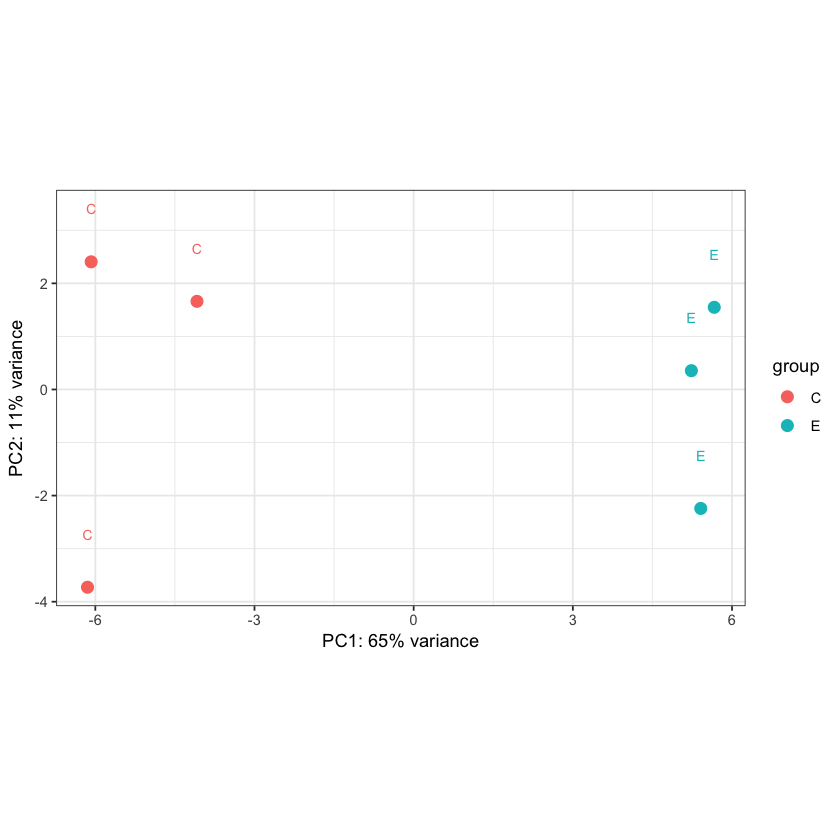

In [9]:
# Plot PCA
p <- DESeq2::plotPCA(rld, ntop = 500, intgroup = "condition")
nudge <- position_nudge(y = 1)
p_new <- p + geom_text(aes(label = condition), position = nudge, size = 3)
p_new <- p_new + theme_bw()
p_new

Comments:
- The groups "C" and "E" are well-separated, which could indicate:
- The treatment effect or biological condition is strongly influencing the data.
- The PCA is successfully capturing meaningful variation in the dataset.
- Further investigation might involve checking which genes or features contribute most to PC1 and PC2 to understand the biological factors driving the separation.

## Hierrachical Clustering Method

Since the majority of genes are not differentially expressed, samples generally have high correlations with each other (values higher than 0.80). 
Samples below 0.80 may indicate an outlier in your data and/or some sample contamination.

In [10]:
rld_mat <- assay(rld)
head(rld_mat)

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
7SK,2.855664,2.872095,2.880119,2.861006,2.893169,2.866568
A1BG-AS1,4.686222,4.544367,4.586583,4.664588,4.565969,4.563715
A2M-AS1,4.995439,5.127592,5.101964,4.994356,4.965982,4.973740
A2ML1-AS1,4.129727,4.175544,4.108406,4.118131,4.123503,4.118218
A2ML1-AS2,3.208127,3.159729,3.160165,3.129485,3.140582,3.202441
A2MP1,3.791593,3.762325,3.794266,3.777426,3.740261,3.829113


In [11]:
rld_cor <- cor(rld_mat)
rld_cor

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
X_filesTien_Cont1_S25sorted,1.0000000,0.9993502,0.9993583,0.9989359,0.9988826,0.9988423
X_filesTien_Cont2_S26sorted,0.9993502,1.0000000,0.9996317,0.9989228,0.9988905,0.9988361
X_filesTien_Cont3_S27sorted,0.9993583,0.9996317,1.0000000,0.9989339,0.9988671,0.9988616
X_filesTien_Zn1_S28sorted,0.9989359,0.9989228,0.9989339,1.0000000,0.9996516,0.9996102
X_filesTien_Zn2_S29sorted,0.9988826,0.9988905,0.9988671,0.9996516,1.0000000,0.9995962
X_filesTien_Zn3_S30sorted,0.9988423,0.9988361,0.9988616,0.9996102,0.9995962,1.0000000


### 1. **Rows and Columns**
- **Rows**: Represent the individual samples, such as `WT_C_3`, `WT_C_1`, etc.
- **Columns**: Also represent the same samples. This symmetry indicates that the heatmap visualizes pairwise comparisons between the samples.
- Both rows and columns are clustered hierarchically to group similar samples together.

---

### 2. **Dendrograms**
- The dendrograms on the top and left of the heatmap show hierarchical clustering of the samples.
  - Samples with shorter branches are more similar to each other.
  - For example, `WT_C_3`, `WT_C_1`, and `WT_C_2` cluster closely, indicating strong similarity within this group.
  - Similarly, `WT_E_1`, `WT_E_2`, and `WT_E_3` form a separate cluster, suggesting distinct differences between group "C" and group "E."

---

### 3. **Heatmap Color Gradient**
- The color scale on the right indicates the similarity or distance between samples:
  - **Red (close to 1)**: Indicates high similarity between samples.
  - **Blue (closer to 0.94)**: Indicates lower similarity.
- For example, samples from the same condition (`C` or `E`) have higher similarity (red regions along the diagonal for respective clusters).
- Cross-group comparisons (e.g., `WT_C_*` vs. `WT_E_*`) show lower similarity (blue regions), indicating distinct differences between the conditions.

---

### 4. **Conditions**
- The top annotation bar shows the conditions (`C` in red, `E` in blue).
- The conditions correlate well with the clustering:
  - All `C` samples cluster together, and all `E` samples form another cluster.

---

### 5. **Interpretation**
- **Intra-group similarity**: Samples within the same condition (`C` or `E`) are highly similar to each other, as indicated by the clustering and red blocks.
- **Inter-group differences**: There is a clear distinction between the `C` and `E` groups, as indicated by the blue blocks in off-diagonal regions.
- This suggests that the experimental condition (e.g., treatment vs. control) significantly influences the sample profiles.

---

### 6. **Use Case**
- This heatmap could represent sample distances or correlations derived from gene expression data, demonstrating how experimental conditions (`C` and `E`) influence expression patterns.
- The results validate that the conditions have distinct profiles, suitable for further downstream analysis.

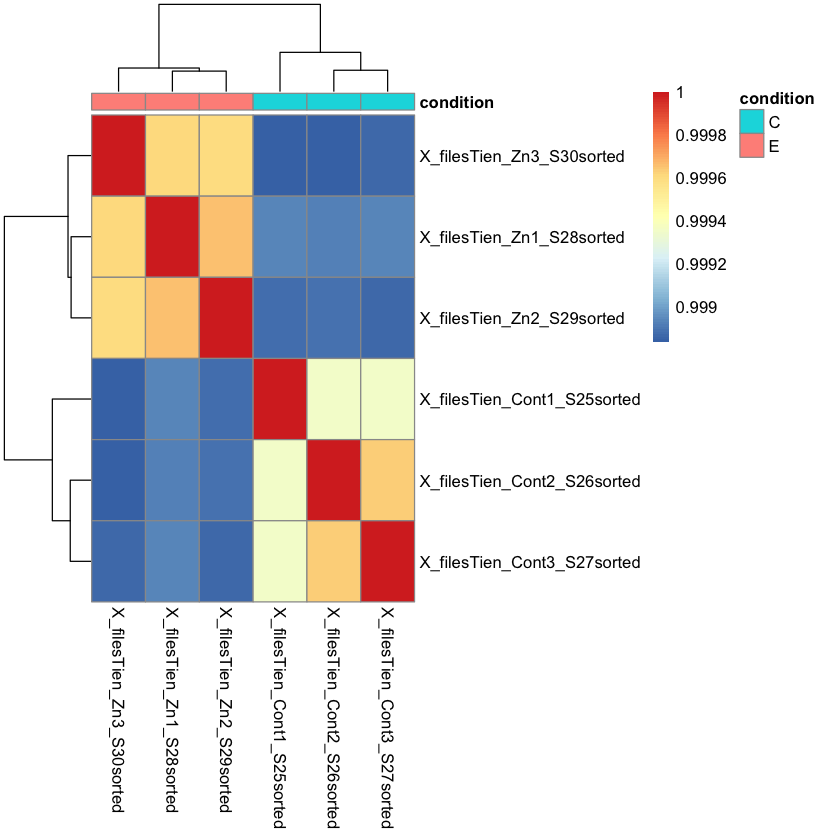

In [12]:
# Plot heatmap
pheatmap(rld_cor, annotation = col_name[, c("condition"), drop = FALSE])

Comments:
- This heatmap could represent sample distances or correlations derived from gene expression data, demonstrating how experimental conditions (C and E) influence expression patterns.
- The results validate that the conditions have distinct profiles, suitable for further downstream analysis.

# Running DESeq2

- DESeq2 will model the raw counts, using normalization factors **(size factors)** to account for differences in library depth
- Then, it will estimate the **gene-wise dispersions** and shrink these estimates to generate more accurate estimates of dispersion to model the counts.
- Finally, DESeq2 will fit the **negative binomial model** and perform **hypothesis testing** using the Wald test or Likelihood Ratio test.

In [13]:
# Run DESeq2 differential expression analysis
dds <- DESeq(dds)
dds

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 14430 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(14430): 7SK A1BG-AS1 ... hsa-mir-8072 snoU2_19
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): X_filesTien_Cont1_S25sorted X_filesTien_Cont2_S26sorted
  ... X_filesTien_Zn2_S29sorted X_filesTien_Zn3_S30sorted
colData names(2): condition sizeFactor

In [14]:
# save dds object
saveRDS(dds, "data/dds.rds")


### 1. **Axes**
- **x-axis (Mean of normalized counts)**: Represents the average expression level (log-transformed) of genes across samples.
- **y-axis (Dispersion estimate)**: Represents the variability (dispersion) of gene expression relative to their mean expression. 

---

### 2. **Data Points**
- **Black dots (`gene-est`)**: Each dot represents an individual gene, showing its raw dispersion before any adjustments. 
  - Genes with lower expression tend to have higher dispersion due to technical noise.
- **Red line (`fitted`)**: Represents the fitted trend line showing the expected relationship between mean expression and dispersion. 
  - Dispersion typically decreases as mean expression increases (genes with high expression tend to have more stable measurements).
- **Blue dots (`final`)**: Represent the dispersion values after applying shrinkage or other normalization methods.
  - Shrinkage reduces extreme dispersion estimates for low-expression genes, making them more reliable.

---

### 3. **Purpose**
This plot is commonly used in **differential expression analysis**:
- To identify genes with unusually high or low dispersion compared to what is expected for their mean expression level.
- Dispersion values are critical for downstream statistical models (e.g., DESeq2) to determine which genes are significantly differentially expressed.

---

### 4. **Interpretation**
- **High expression genes (right side)**: Tend to have lower dispersion (tight clustering near the red line).
- **Low expression genes (left side)**: Have higher variability due to technical noise, but blue points show normalized dispersion after shrinkage.
- The fit of the red line and the placement of blue points indicate whether the normalization process is effective.

---

### 5. **Conclusion**
This plot helps validate the assumptions of dispersion modeling in RNA-Seq data:
- **Black dots**: Raw variability before adjustment.
- **Red line**: Baseline relationship between expression and dispersion.
- **Blue dots**: Improved estimates after normalization.

In [15]:
# load dds object
dds <- readRDS("data/dds.rds")
head(counts(dds, normalized = TRUE))

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
7SK,0.00000,7.424778,8.682904,5.665332,10.892091,6.479303
A1BG-AS1,62.52693,16.199515,22.189643,33.425460,19.221337,18.512294
A2M-AS1,17.86484,51.298464,45.826437,27.193595,22.424893,23.140368
A2ML1-AS1,17.86484,24.974252,14.471507,15.862930,16.658492,15.735450
A2ML1-AS2,26.79726,8.099757,8.200520,4.532266,5.766401,13.884221
A2MP1,17.86484,10.799677,15.436274,13.030264,7.688535,21.289138


In [16]:
# show results as data frame
res <- results(dds)

# convert to dataframe
res_df <- as.data.frame(res)
head(res_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7SK,6.524068,0.127862224,0.8905382,0.14357860,0.8858332,NA
A1BG-AS1,28.679197,-0.090175200,0.5146600,-0.17521316,0.8609121,0.9442966
A2M-AS1,31.291432,-0.852683758,0.4181076,-2.03938822,0.0414113,0.1637656
A2ML1-AS1,17.594578,-0.266422145,0.5389822,-0.49430600,0.6210901,NA
A2ML1-AS2,11.213404,-0.437107484,0.7622867,-0.57341614,0.5663630,NA
A2MP1,14.351454,0.003607133,0.6304721,0.00572132,0.9954351,NA


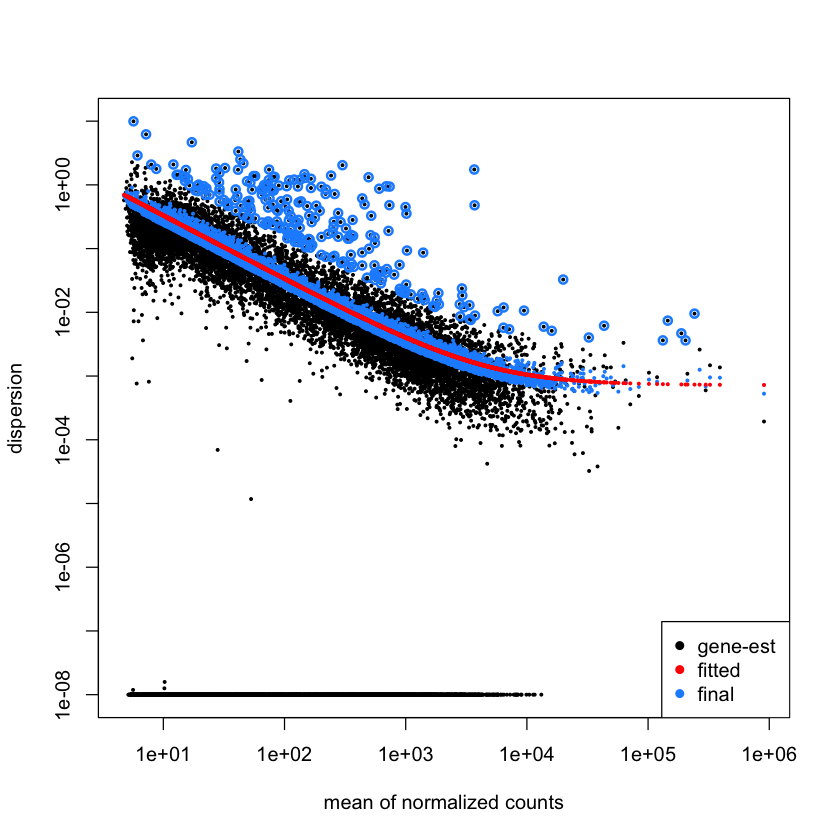

In [17]:
plotDispEsts(dds)

In [18]:
# Check the coefficients for the comparison
resultsNames(dds)

[1] "Intercept"        "condition_E_vs_C"

In [19]:
# Generate results object
res <- results(dds,
               name = "condition_E_vs_C",
               alpha = 0.05)
res

log2 fold change (MLE): condition E vs C 
Wald test p-value: condition E vs C 
DataFrame with 14430 rows and 6 columns
               baseMean log2FoldChange     lfcSE       stat    pvalue      padj
              <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
7SK             6.52407      0.1278622  0.890538   0.143579 0.8858332        NA
A1BG-AS1       28.67920     -0.0901752  0.514660  -0.175213 0.8609121  0.947051
A2M-AS1        31.29143     -0.8526838  0.418108  -2.039388 0.0414113  0.170624
A2ML1-AS1      17.59458     -0.2664221  0.538982  -0.494306 0.6210901        NA
A2ML1-AS2      11.21340     -0.4371075  0.762287  -0.573416 0.5663630        NA
...                 ...            ...       ...        ...       ...       ...
hsa-mir-1199    7.86299     -0.0521009  0.820685 -0.0634847 0.9493806        NA
hsa-mir-490   135.32502     -0.4974386  0.193908 -2.5653371 0.0103076 0.0602802
hsa-mir-6723 3701.82381     -1.8068057  0.815298 -2.2161281 0.0266827 0.1253252
h

In [20]:
# Shrink the log2 fold changes to be more appropriate using the apeglm method
# should cite [paper]() when using this method
res <- lfcShrink(dds,
                 coef = "condition_E_vs_C",
                 res = res,
                 type = "apeglm")
res

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): condition E vs C 
Wald test p-value: condition E vs C 
DataFrame with 14430 rows and 5 columns
               baseMean log2FoldChange     lfcSE    pvalue      padj
              <numeric>      <numeric> <numeric> <numeric> <numeric>
7SK             6.52407     0.00466854  0.164928 0.8858332        NA
A1BG-AS1       28.67920    -0.00801885  0.160321 0.8609121  0.947051
A2M-AS1        31.29143    -0.17130714  0.275399 0.0414113  0.170624
A2ML1-AS1      17.59458    -0.02370913  0.162419 0.6210901        NA
A2ML1-AS2      11.21340    -0.01884118  0.165673 0.5663630        NA
...                 ...            ...       ...       ...       ...
hsa-mir-1199    7.86299    -0.00208328  0.164306 0.9493806        NA
hsa-mir-490   135.32502    -0.35114851  0.210021 0.0103076 0.0602802
hsa-mir-6723 3701.82381    -0.07112774  0.188059 0.0266827 0.1253252
hsa-mir-8072   46.10530     0.00658401  0.154626 0.9172064 0.9687068
snoU2_19        5.35161     0.00696554  0.165478 0.81

In [21]:
# write results to file
write.csv(as.data.frame(res), file = "data/gene_deseq2_results.csv")

In [22]:
# Turn the DESeq2 results object into a tibble for use with tidyverse functions
res_tbl <- res %>%
  data.frame() %>%
  rownames_to_column(var = "gene") %>%
  as_tibble() %>%
  arrange(padj)

head(res_tbl)  

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-RNR2,904848.616,2.307590,0.02724077,0.000000e+00,0.000000e+00
MT-TP,3253.096,1.944385,0.05412532,1.003573e-284,5.411264e-281
MT-ND5,298801.231,1.111986,0.03115547,4.333748e-280,1.557838e-276
MTRNR2L2,2609.833,1.974944,0.05587488,2.128453e-275,5.738310e-272
MT-ATP6,118615.796,-1.112057,0.03392554,7.591171e-237,1.637264e-233
MT-ATP8,43908.463,-1.334777,0.04099192,5.001372e-234,8.989132e-231


In [23]:
# Write all results to file
save_path <- file.path(
  "data",
  paste0(levels(condition)[2], "_vs_", levels(condition)[1], "_all_genes.csv")
)

write.csv(
  res_tbl,
  save_path,
  quote = FALSE,
  row.names = FALSE
)